## 
#### 108998408 - Raden Gunawan
### Training Face Classifier

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 6
img_rows, img_cols = 100, 100
batch_size = 16

from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '../input/face-datasets/face_datasets'
validation_data_dir = '../input/face-testing/face_datasets_tests'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,                    # normalize pixel values to [0,1]
      rotation_range=45,                 # randomly applies rotations until max. 90 degree
      width_shift_range=0.3,            # randomly applies width shifting
      height_shift_range=0.3,             # randomly applies height shifting
      horizontal_flip=True,               # randonly flips the image
      fill_mode='nearest')            # uses the fill mode nearest to fill gaps created by the above
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 4800 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.


### Let's define our model

##### create our layers to replicate AlexNet

In [2]:
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import ZeroPadding2D

In [3]:
l2_reg = 0

# Initialize model
model = Sequential()

# 1st Conv Layer 
model.add(Conv2D(96, (11, 11), input_shape=(img_rows, img_cols, 3),
    padding='same', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Conv Layer 
model.add(Conv2D(256, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Conv Layer 
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Conv Layer 
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 5th Conv Layer 
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 1st FC Layer
model.add(Flatten())
model.add(Dense(3072))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 2nd FC Layer
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 3rd FC Layer
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

print(model.summary())

#model.compile(loss = 'categorical_crossentropy',
#              optimizer = keras.optimizers.Adadelta(),
#              metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 96)      34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 96)      384       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 96)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 256)       0

In [4]:
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("face_classifier_by_Raden_v01.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 4800
nb_validation_samples = 1200


In [5]:
import timeit
start = timeit.default_timer()

epochs = 50

print('Training STARTED!!')
print('....................')
history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

print('Training Finished!!')
stop = timeit.default_timer()

Training STARTED!!
....................
Epoch 1/50
300/300 [==============================] - 35s 104ms/step - loss: 1.8267 - accuracy: 0.2301 - val_loss: 11.6023 - val_accuracy: 0.2150

Epoch 00001: val_loss improved from inf to 11.60229, saving model to face_classifier_by_Raden_v01.h5
Epoch 2/50
300/300 [==============================] - 31s 103ms/step - loss: 1.7283 - accuracy: 0.2716 - val_loss: 2.5327 - val_accuracy: 0.2050

Epoch 00002: val_loss improved from 11.60229 to 2.53272, saving model to face_classifier_by_Raden_v01.h5
Epoch 3/50
300/300 [==============================] - 31s 103ms/step - loss: 1.6851 - accuracy: 0.3023 - val_loss: 1.7044 - val_accuracy: 0.3025

Epoch 00003: val_loss improved from 2.53272 to 1.70441, saving model to face_classifier_by_Raden_v01.h5
Epoch 4/50
300/300 [==============================] - 31s 102ms/step - loss: 1.6689 - accuracy: 0.3258 - val_loss: 1.8158 - val_accuracy: 0.2817

Epoch 00004: val_loss did not improve from 1.70441
Epoch 5/50
300

### Displaying our Confusion Matrix

In [6]:
#generator= train_datagen.flow_from_directory("train", batch_size=batch_size)
#label_map = (generator.class_indices)

#train_generator
class_labels = (train_generator.class_indices)

In [7]:
class_labels

{'ASEAN': 0,
 'African': 1,
 'Arab': 2,
 'European': 3,
 'Indian': 4,
 'Taiwanese': 5}

In [8]:
validation_generator.classes

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [13]:
list(class_labels.values())

['ASEAN', 'African', 'Arab', 'European', 'Indian', 'Taiwanese']

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))


Confusion Matrix
[[  0  24   9  14   7 146]
 [  0  58  16  15  29  82]
 [  1  20   5  14  11 149]
 [  3  20   0  28  12 137]
 [  0  44   9  16  15 116]
 [  0   1   0   1   2 196]]


In [15]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       ASEAN       0.00      0.00      0.00       200
     African       0.35      0.29      0.32       200
        Arab       0.13      0.03      0.04       200
    European       0.32      0.14      0.19       200
      Indian       0.20      0.07      0.11       200
   Taiwanese       0.24      0.98      0.38       200

    accuracy                           0.25      1200
   macro avg       0.20      0.25      0.17      1200
weighted avg       0.20      0.25      0.17      1200



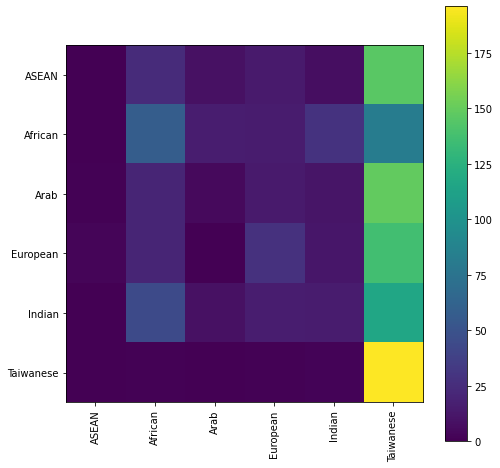

In [19]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('./fruits_fresh_cnn_1.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 4800
nb_validation_samples = 1200

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

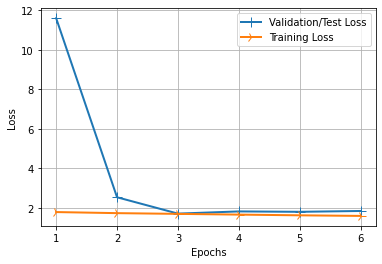

In [16]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


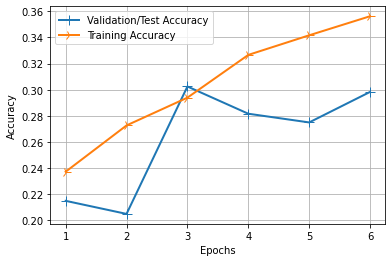

In [17]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


## Saving Model

#### Let's save our history file

In [20]:
import pickle 

pickle_out = open("face_classifier_Raden1.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

#### Loading out saved history is as simple as these two lines

In [ ]:
import pickle 

pickle_in = open("face_classifier_Raden1.pickle","rb")
saved_history = pickle.load(pickle_in)
print(saved_history)

### Testing our fruit classifier

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = './fruits-360/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()